14:04:28 - cmdstanpy - INFO - Chain [1] start processing
14:04:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0574
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
ARIMA MAPE: 10.24%
SARIMA MAPE: 9.62%
Prophet MAPE: 9.52%
LSTM MAPE: 8.68%
Regression MAPE: 9.15%
Weekly Sales Prediction (ARIMA): 974.1019523159803
Weekly Sales Prediction (SARIMA): 980.8152417217526
Weekly Sales Prediction (Prophet): 1009.1046795659819
Weekly Sales Prediction (LSTM): 1016.5494995117

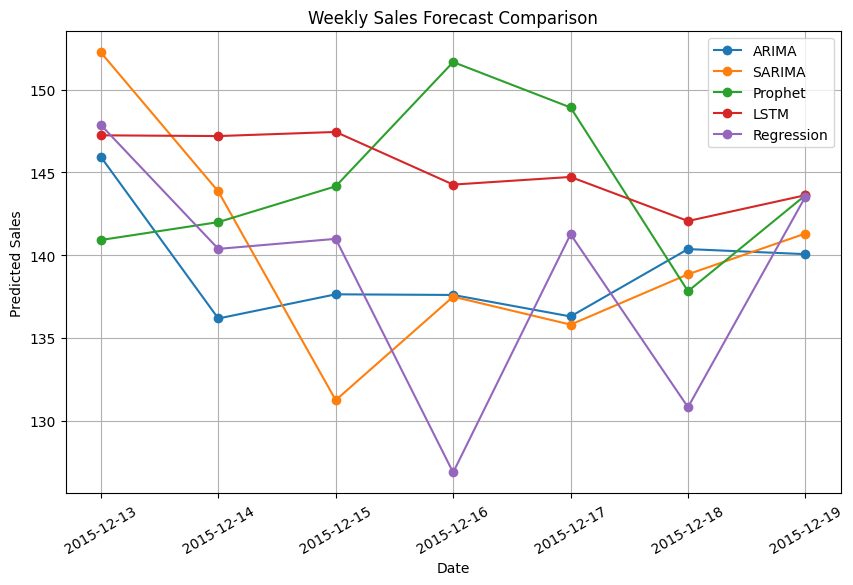

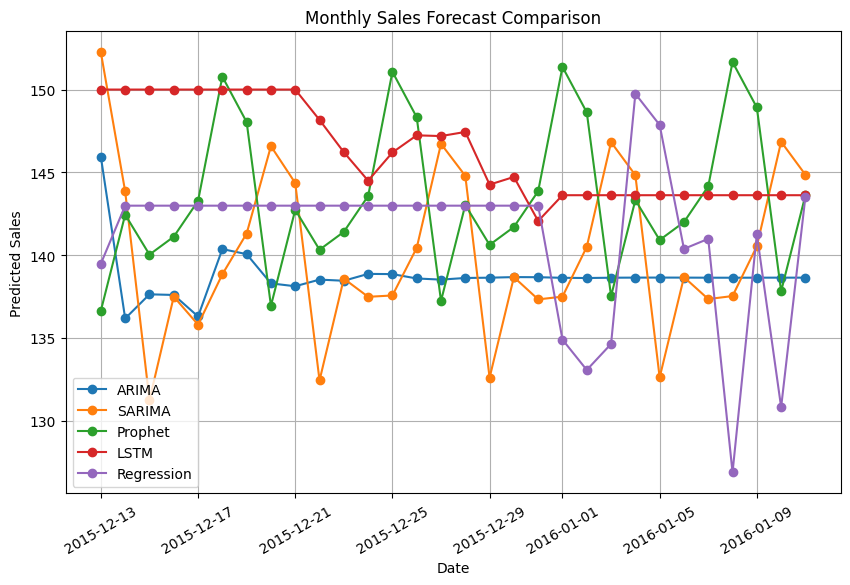

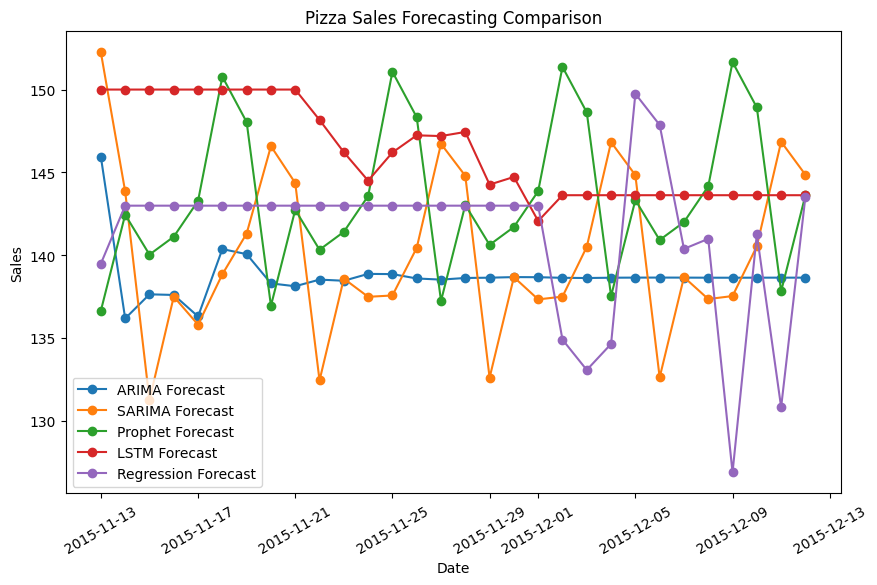

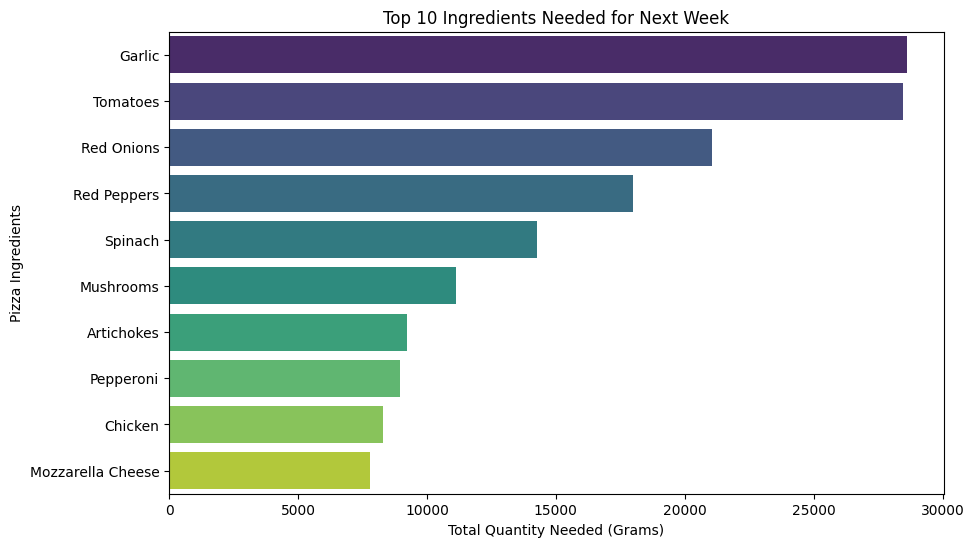

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

ingredients_df = pd.read_csv(r"C:\Users\Lenovo\Downloads\Pizza_ingredients - Pizza_ingredients.csv")
sales_df = pd.read_csv(r"C:\Users\Lenovo\Downloads\Pizza_Sale - pizza_sales.csv")

# Convert 'order_date' to datetime, handling mixed formats
sales_df['order_date'] = pd.to_datetime(sales_df['order_date'], errors='coerce', dayfirst=True)

# Drop rows where 'order_date' conversion failed (NaT values)
sales_df = sales_df.dropna(subset=['order_date'])

# Drop rows with missing values (if any)
sales_df.dropna(inplace=True)
ingredients_df.dropna(inplace=True)

# Handle outliers by capping extreme values in quantity (e.g., 99th percentile)
q99 = sales_df['quantity'].quantile(0.99)
sales_df['quantity'] = np.where(sales_df['quantity'] > q99, q99, sales_df['quantity'])

# Feature Engineering
sales_df['day_of_week'] = sales_df['order_date'].dt.day_name()
sales_df['month'] = sales_df['order_date'].dt.month
sales_df['year'] = sales_df['order_date'].dt.year

# Ensure there are no duplicate 'order_date' values by aggregating
sales_df = sales_df.groupby('order_date').agg({'quantity': 'sum'}).reset_index()

# Set 'order_date' as the index for time series analysis
sales_df.set_index('order_date', inplace=True)
sales_df = sales_df.asfreq('D')  # Ensure the data has a daily frequency (fill missing dates)
sales_df['quantity'] = sales_df['quantity'].ffill()  # Fill missing values by forward filling

# Train/Test Split 
train_data = sales_df['quantity'][:-30]
test_data = sales_df['quantity'][-30:]

# ARIMA Model 
arima_model = ARIMA(train_data, order=(5, 1, 0))
arima_fit = arima_model.fit()
forecast_arima = arima_fit.forecast(steps=30)
forecast_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

#  SARIMA Model 
sarima_model = SARIMAX(train_data, order=(5, 1, 0), seasonal_order=(1, 1, 1, 7))
sarima_fit = sarima_model.fit()
forecast_sarima = sarima_fit.forecast(steps=30)

# Prophet Model
prophet_data = sales_df.reset_index()[['order_date', 'quantity']].rename(columns={'order_date': 'ds', 'quantity': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)
future = prophet_model.make_future_dataframe(periods=30)
forecast_prophet = prophet_model.predict(future)

# LSTM Model 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sales_df['quantity'].values.reshape(-1, 1))
train_size = int(len(scaled_data) * 0.8)
train_data_lstm = scaled_data[:train_size]
test_data_lstm = scaled_data[train_size:]

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

seq_length = 10
x_train, y_train = create_sequences(train_data_lstm, seq_length)
x_test, y_test = create_sequences(test_data_lstm, seq_length)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=False, input_shape=(x_train.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(x_train, y_train, epochs=10, batch_size=16)

predicted_lstm = lstm_model.predict(x_test)
predicted_lstm = scaler.inverse_transform(predicted_lstm)

# Ensure predicted_lstm and test_data[seq_length:] have the same length
predicted_lstm = predicted_lstm[-len(test_data[seq_length:]):]

# Regression Model
sales_df['lag_1'] = sales_df['quantity'].shift(1)
sales_df['lag_2'] = sales_df['quantity'].shift(2)
sales_df.dropna(inplace=True)
train_reg = sales_df[:-30]
test_reg = sales_df[-30:]

x_train_reg = train_reg[['lag_1', 'lag_2']]
y_train_reg = train_reg['quantity']
x_test_reg = test_reg[['lag_1', 'lag_2']]
y_test_reg = test_reg['quantity']

reg_model = LinearRegression()
reg_model.fit(x_train_reg, y_train_reg)
predicted_reg = reg_model.predict(x_test_reg)

# Performance Evaluation
mape_arima = mean_absolute_percentage_error(test_data, forecast_arima) * 100
mape_sarima = mean_absolute_percentage_error(test_data, forecast_sarima) * 100
mape_prophet = mean_absolute_percentage_error(test_data, forecast_prophet['yhat'][-30:]) * 100
mape_lstm = mean_absolute_percentage_error(test_data[seq_length:], predicted_lstm) * 100
mape_reg = mean_absolute_percentage_error(y_test_reg, predicted_reg) * 100

print(f"ARIMA MAPE: {mape_arima:.2f}%")
print(f"SARIMA MAPE: {mape_sarima:.2f}%")
print(f"Prophet MAPE: {mape_prophet:.2f}%")
print(f"LSTM MAPE: {mape_lstm:.2f}%")
print(f"Regression MAPE: {mape_reg:.2f}%")

# Weekly Forecast
# Generating forecasts for the next 7 days
weekly_forecast_arima = arima_fit.forecast(steps=7).sum()
weekly_forecast_sarima = sarima_fit.forecast(steps=7).sum()
weekly_forecast_prophet = forecast_prophet['yhat'][-7:].sum()
weekly_forecast_lstm = predicted_lstm[-7:].sum()
weekly_forecast_reg = predicted_reg[-7:].sum()

print(f"Weekly Sales Prediction (ARIMA): {weekly_forecast_arima}")
print(f"Weekly Sales Prediction (SARIMA): {weekly_forecast_sarima}")
print(f"Weekly Sales Prediction (Prophet): {weekly_forecast_prophet}")
print(f"Weekly Sales Prediction (LSTM): {weekly_forecast_lstm}")
print(f"Weekly Sales Prediction (Regression): {weekly_forecast_reg}")

# Monthly Forecast 
# Generating forecasts for the next 30 days
monthly_forecast_arima = arima_fit.forecast(steps=30).sum()
monthly_forecast_sarima = sarima_fit.forecast(steps=30).sum()
monthly_forecast_prophet = forecast_prophet['yhat'][-30:].sum()
monthly_forecast_lstm = predicted_lstm[-30:].sum()
monthly_forecast_reg = predicted_reg[-30:].sum()

print(f"Monthly Sales Prediction (ARIMA): {monthly_forecast_arima}")
print(f"Monthly Sales Prediction (SARIMA): {monthly_forecast_sarima}")
print(f"Monthly Sales Prediction (Prophet): {monthly_forecast_prophet}")
print(f"Monthly Sales Prediction (LSTM): {monthly_forecast_lstm}")
print(f"Monthly Sales Prediction (Regression): {monthly_forecast_reg}")

# Ingredient Purchase Order Calculation 
total_pizzas_predicted = forecast_arima[:7].sum()  # Using ARIMA forecast for purchase order calculation

if 'quantity_per_pizza' not in ingredients_df.columns:
    ingredients_df['quantity_per_pizza'] = np.random.uniform(0.1, 1.0, size=len(ingredients_df))  # Random values

ingredients_df['total_quantity_needed'] = ingredients_df['quantity_per_pizza'] * total_pizzas_predicted
ingredients_df = ingredients_df.groupby('pizza_ingredients', as_index=False).agg({'total_quantity_needed': 'sum'})
ingredients_df = ingredients_df.sort_values('total_quantity_needed', ascending=False)

ingredients_df[['pizza_ingredients', 'total_quantity_needed']].to_csv('complete_purchase_order_next_week.csv', index=False)
print("Total Purchase Order for the Next Week (All Ingredients):")
print(ingredients_df[['pizza_ingredients', 'total_quantity_needed']])
ingredients_df.to_csv('Total_Ingredients_Neede',index=False, mode='w', header=True)

# Weekly and Monthly Forecasts 
def plot_forecasts(title, arima, sarima, prophet, lstm, reg, forecast_index):
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_index, arima, label='ARIMA', marker='o')
    plt.plot(forecast_index, sarima, label='SARIMA', marker='o')
    plt.plot(forecast_index, prophet, label='Prophet', marker='o')
    plt.plot(forecast_index, lstm, label='LSTM', marker='o')
    plt.plot(forecast_index, reg, label='Regression', marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Predicted Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=30)
    plt.show()

weekly_forecast_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
plot_forecasts('Weekly Sales Forecast Comparison', 
               arima_fit.forecast(steps=7),
               sarima_fit.forecast(steps=7),
               forecast_prophet['yhat'][-7:],
               predicted_lstm[-7:].flatten(),  
               predicted_reg[-7:],
               weekly_forecast_index)

# Ensure LSTM predictions match the forecast length (30)
lstm_forecast = predicted_lstm[-30:].flatten()

# If LSTM predictions are less than 30, pad with the last value or some logic
if len(lstm_forecast) < 30:
    lstm_forecast = np.pad(lstm_forecast, (0, 30 - len(lstm_forecast)), 'edge')

# Define monthly_forecast_index
monthly_forecast_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
plot_forecasts('Monthly Sales Forecast Comparison', 
               arima_fit.forecast(steps=30),
               sarima_fit.forecast(steps=30),
               forecast_prophet['yhat'][-30:],
               lstm_forecast,  # Use LSTM forecast adjusted to 30 days
               predicted_reg[-30:],
               monthly_forecast_index)

# Ensure LSTM predictions match the forecast length (30)
lstm_forecast = predicted_lstm.flatten()

# If LSTM predictions are less than 30, pad with the last value
if len(lstm_forecast) < 30:
    lstm_forecast = np.pad(lstm_forecast, (0, 30 - len(lstm_forecast)), 'edge')

# Plot forecasts
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, forecast_arima, label='ARIMA Forecast', marker='o')
plt.plot(test_data.index[-30:], forecast_sarima, label='SARIMA Forecast', marker='o')
plt.plot(test_data.index[-30:], forecast_prophet['yhat'][-30:], label='Prophet Forecast', marker='o')
plt.plot(test_data.index[-30:], lstm_forecast[:30], label='LSTM Forecast', marker='o')  # Now using padded LSTM
plt.plot(test_data.index[-30:], predicted_reg[:30], label='Regression Forecast', marker='o')
plt.title('Pizza Sales Forecasting Comparison')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=30)
plt.show()

# Sort ingredients by the total quantity needed and select the top 10
top_10_ingredients = ingredients_df.sort_values(by='total_quantity_needed', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='total_quantity_needed', y='pizza_ingredients',hue='pizza_ingredients' ,data=top_10_ingredients, palette='viridis')
plt.title('Top 10 Ingredients Needed for Next Week')
plt.xlabel('Total Quantity Needed (Grams)')
plt.ylabel('Pizza Ingredients')
plt.show()

